In [1]:
import os

output_models_path = os.environ["DATA"] + "/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/"
output_figures_path = os.environ["FIGURES"] + "/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/"


pop_size = 1000
k_to_replace = 10
max_steps = 800
record_history = False

entropy_weights = [0.1, 1, 10, 100, 1000, 0]
entropy_functions = ["entropy_ifg", "entropy_gen_scaffolds", "entropy_checkmol", "entropy_shg_1"]


In [2]:
from itertools import product

def model_id_to_model_params(model_id):
    
    exp_id = model_id // 10
    run_id = model_id % 10
    
    all_exp_param_tuples = list(product(entropy_weights, entropy_functions))
    
    entropy_function = all_exp_param_tuples[exp_id][1]
    entropy_weight = all_exp_param_tuples[exp_id][0]
    
    if entropy_weight == 0:
        entropy_function = "no_entropy"
    
    return entropy_weight, entropy_function, run_id


In [3]:
from os.path import join
import pandas as pd

def compute_model_path(entropy_weight, entropy_function, run_id):

    # Computing model path
    model_name = "entropy_weight_" + str(entropy_weight) + "_" + str(entropy_function)
    model_path = join(output_models_path, model_name, str(run_id))
    return model_path

def extract_convergence_vs_calls(steps_path, convergence_key, curr_batch_max_calls=None):
    
    with open(steps_path, "r") as f:
        steps_dict = pd.read_csv(f)
        
        convergence = np.array(steps_dict["qed_"+convergence_key])
        calls = np.array(steps_dict["objective_calls"])
            
    return convergence, calls

def normalizer_x_ticks(convergence, calls, max_calls=10000000):

#     new_calls = np.arange(0, np.max(calls), step)
    
    geomspace = np.geomspace(1, 10000000, 1000)
    new_calls = geomspace[geomspace <= np.max(calls)]

    new_convergence = np.interp(new_calls, calls, convergence)

    return new_convergence, new_calls
    
def extract_all_data(convergence_key, normalize_x_ticks=False):
    
    d = {
        "run_id": np.array([]),
        "entropy_weight": np.array([]),
        "entropy": np.array([]),
        convergence_key + " qed": np.array([]),
        "# calls": np.array([])
    }
    
    for i in range(210):
     
        entropy_weight, entropy_function, run_id = model_id_to_model_params(i)
        model_path = compute_model_path(entropy_weight, entropy_function, run_id)
        convergence, calls = extract_convergence_vs_calls(join(model_path, "steps.csv"), convergence_key)
        
        if normalize_x_ticks:
            convergence, calls = normalizer_x_ticks(convergence, calls)
        
        
        if entropy_function == "no_entropy":
            
            for entropy_weight in [0.1, 1, 10, 100, 1000]:
                
                run_id = np.full(convergence.shape, run_id)
                entropy_weight = np.full(convergence.shape, entropy_weight)
                entropy = np.full(convergence.shape, entropy_function)

                d["run_id"] = np.concatenate([d["run_id"], run_id])
                d["entropy_weight"] = np.concatenate([d["entropy_weight"], entropy_weight])
                d["entropy"] = np.concatenate([d["entropy"], entropy])
                d[convergence_key + " qed"] = np.concatenate([d[convergence_key + " qed"], convergence])
                d["# calls"] = np.concatenate([d["# calls"], calls])
            
        else:
        
            run_id = np.full(convergence.shape, run_id)
            entropy_weight = np.full(convergence.shape, entropy_weight)
            entropy = np.full(convergence.shape, entropy_function)

            d["run_id"] = np.concatenate([d["run_id"], run_id])
            d["entropy_weight"] = np.concatenate([d["entropy_weight"], entropy_weight])
            d["entropy"] = np.concatenate([d["entropy"], entropy])
            d[convergence_key + " qed"] = np.concatenate([d[convergence_key + " qed"], convergence])
            d["# calls"] = np.concatenate([d["# calls"], calls])
        
    return pd.DataFrame.from_dict(d)


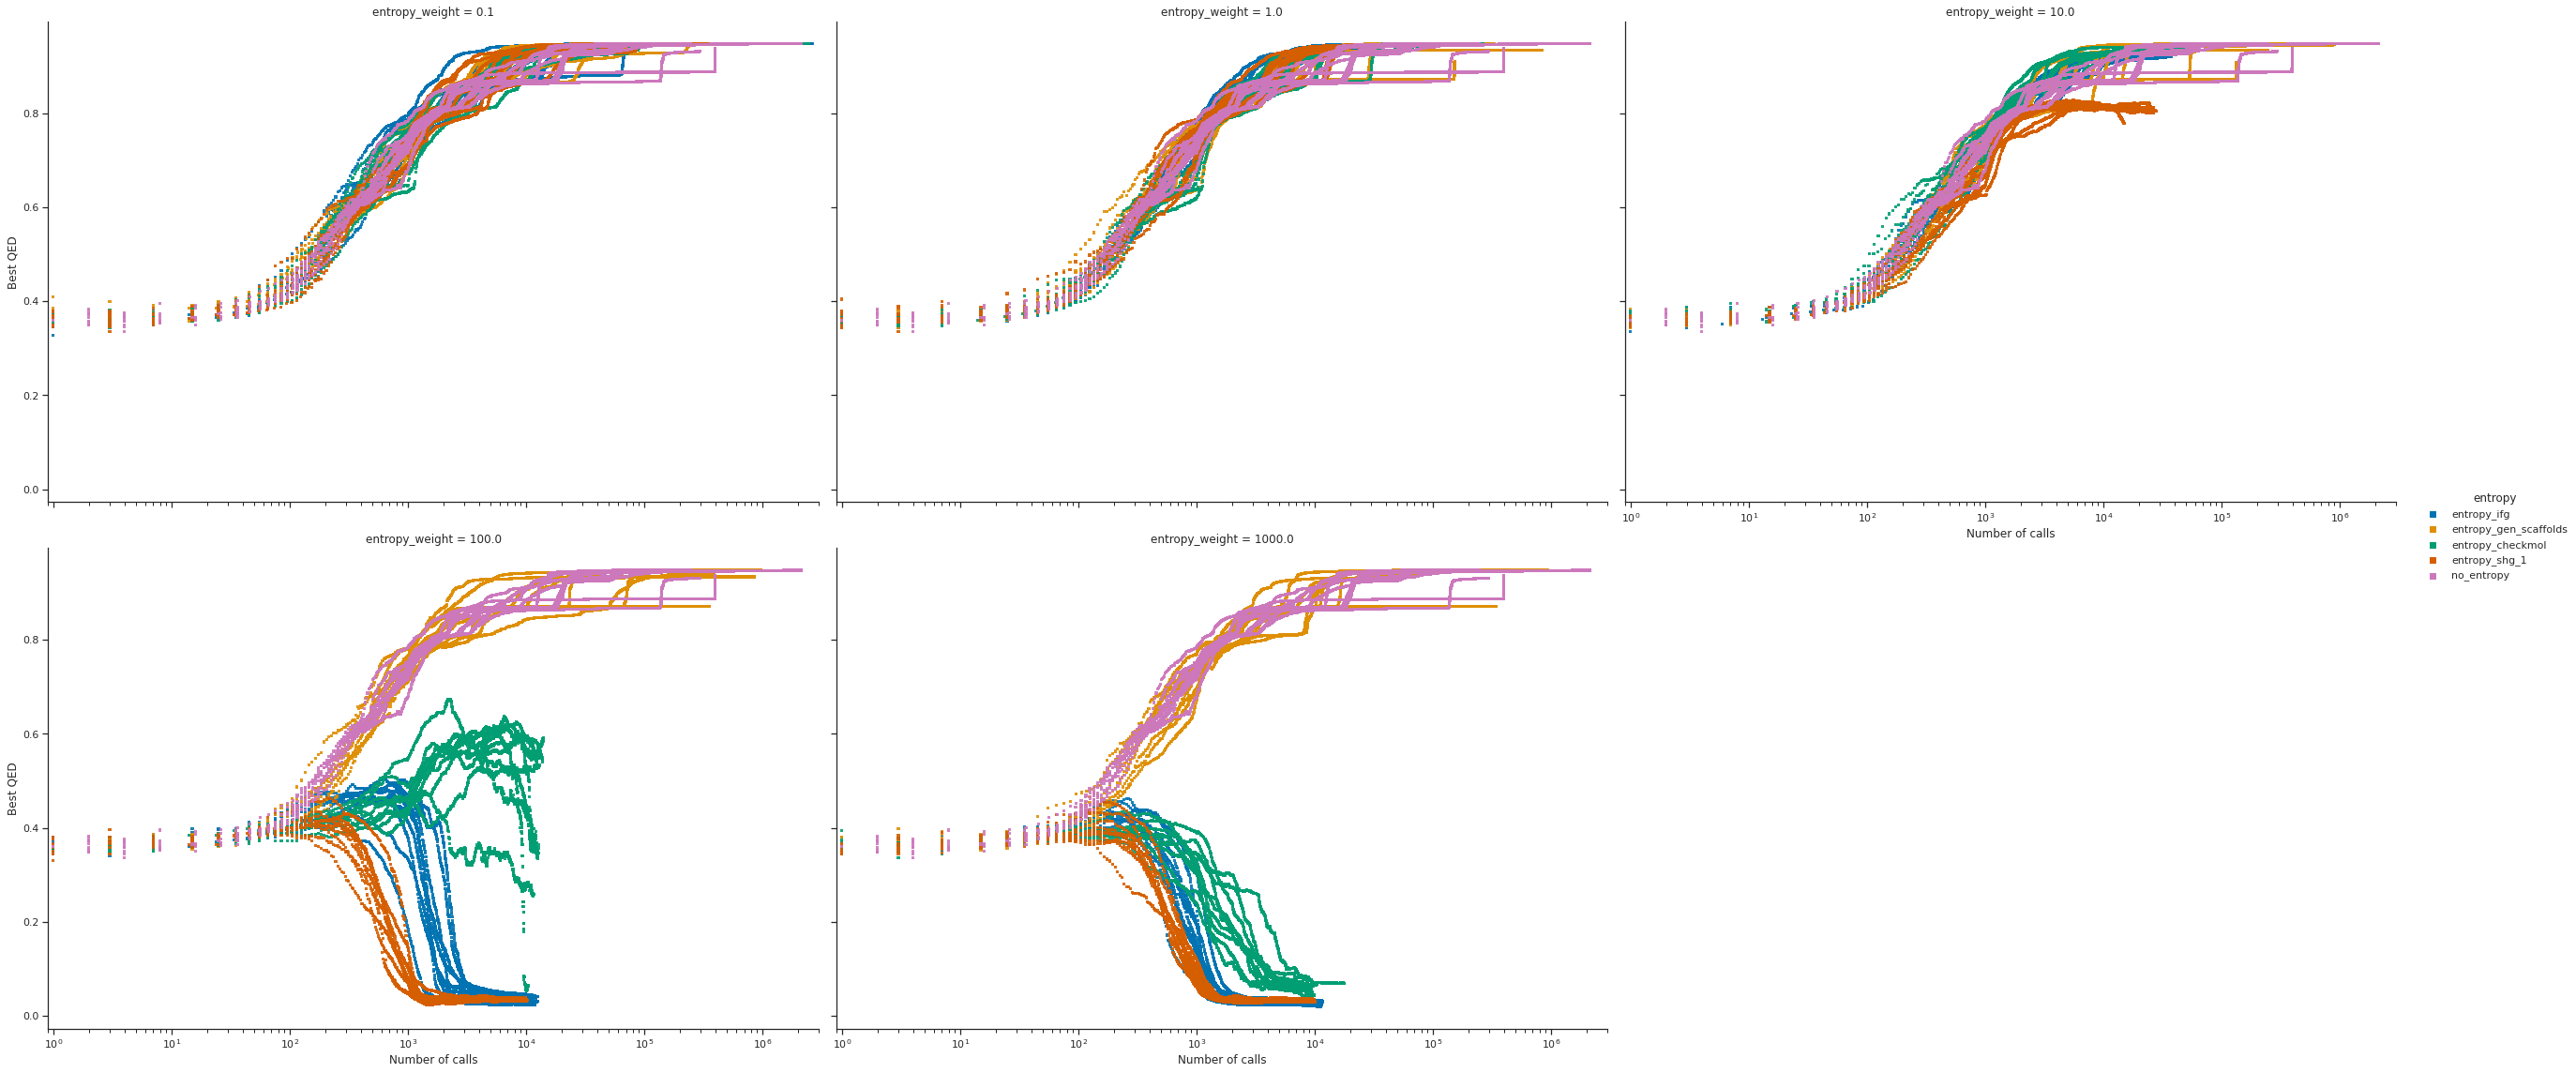

In [6]:
import numpy as np

import seaborn as sns
sns.set(style="ticks", palette="colorblind", color_codes=True)
import matplotlib.pyplot as plt
from os import makedirs

        

def plot_score_vs_calls(convergence_key, normalize_x_ticks=False, kind="scatter"):
    
    makedirs(output_figures_path, exist_ok=True)
    
    d = extract_all_data(convergence_key, normalize_x_ticks=normalize_x_ticks)
    
    if kind == "scatter":
        p = sns.relplot(
            data=d, kind=kind,
            x="# calls", y=convergence_key + " qed", col="entropy_weight",
            hue="entropy", style="entropy", col_wrap=3, height=8, aspect=3/2, s=10, 
            markers=[",", ",", ",", ",", ","], alpha=0.9, linewidth=0
        )

    elif kind == "line":
        p = sns.relplot(
            data=d, kind=kind,
            x="# calls", y=convergence_key + " qed", col="entropy_weight",
            hue="entropy", col_wrap=3, height=8, aspect=3/2
        )

        
    plt.xscale("log")    
    p.set(xlim=(0.9,3000000))
    p.set(xlabel="Number of calls", ylabel="Best QED")

    
    if normalize_x_ticks:
        filename = kind + "_convergence_regular_ticks" + convergence_key + ".png"
    else:
        filename = kind + "_convergence_" + convergence_key + ".png"

    plt.savefig(join(output_figures_path, filename), dpi=300)


plot_score_vs_calls("med")


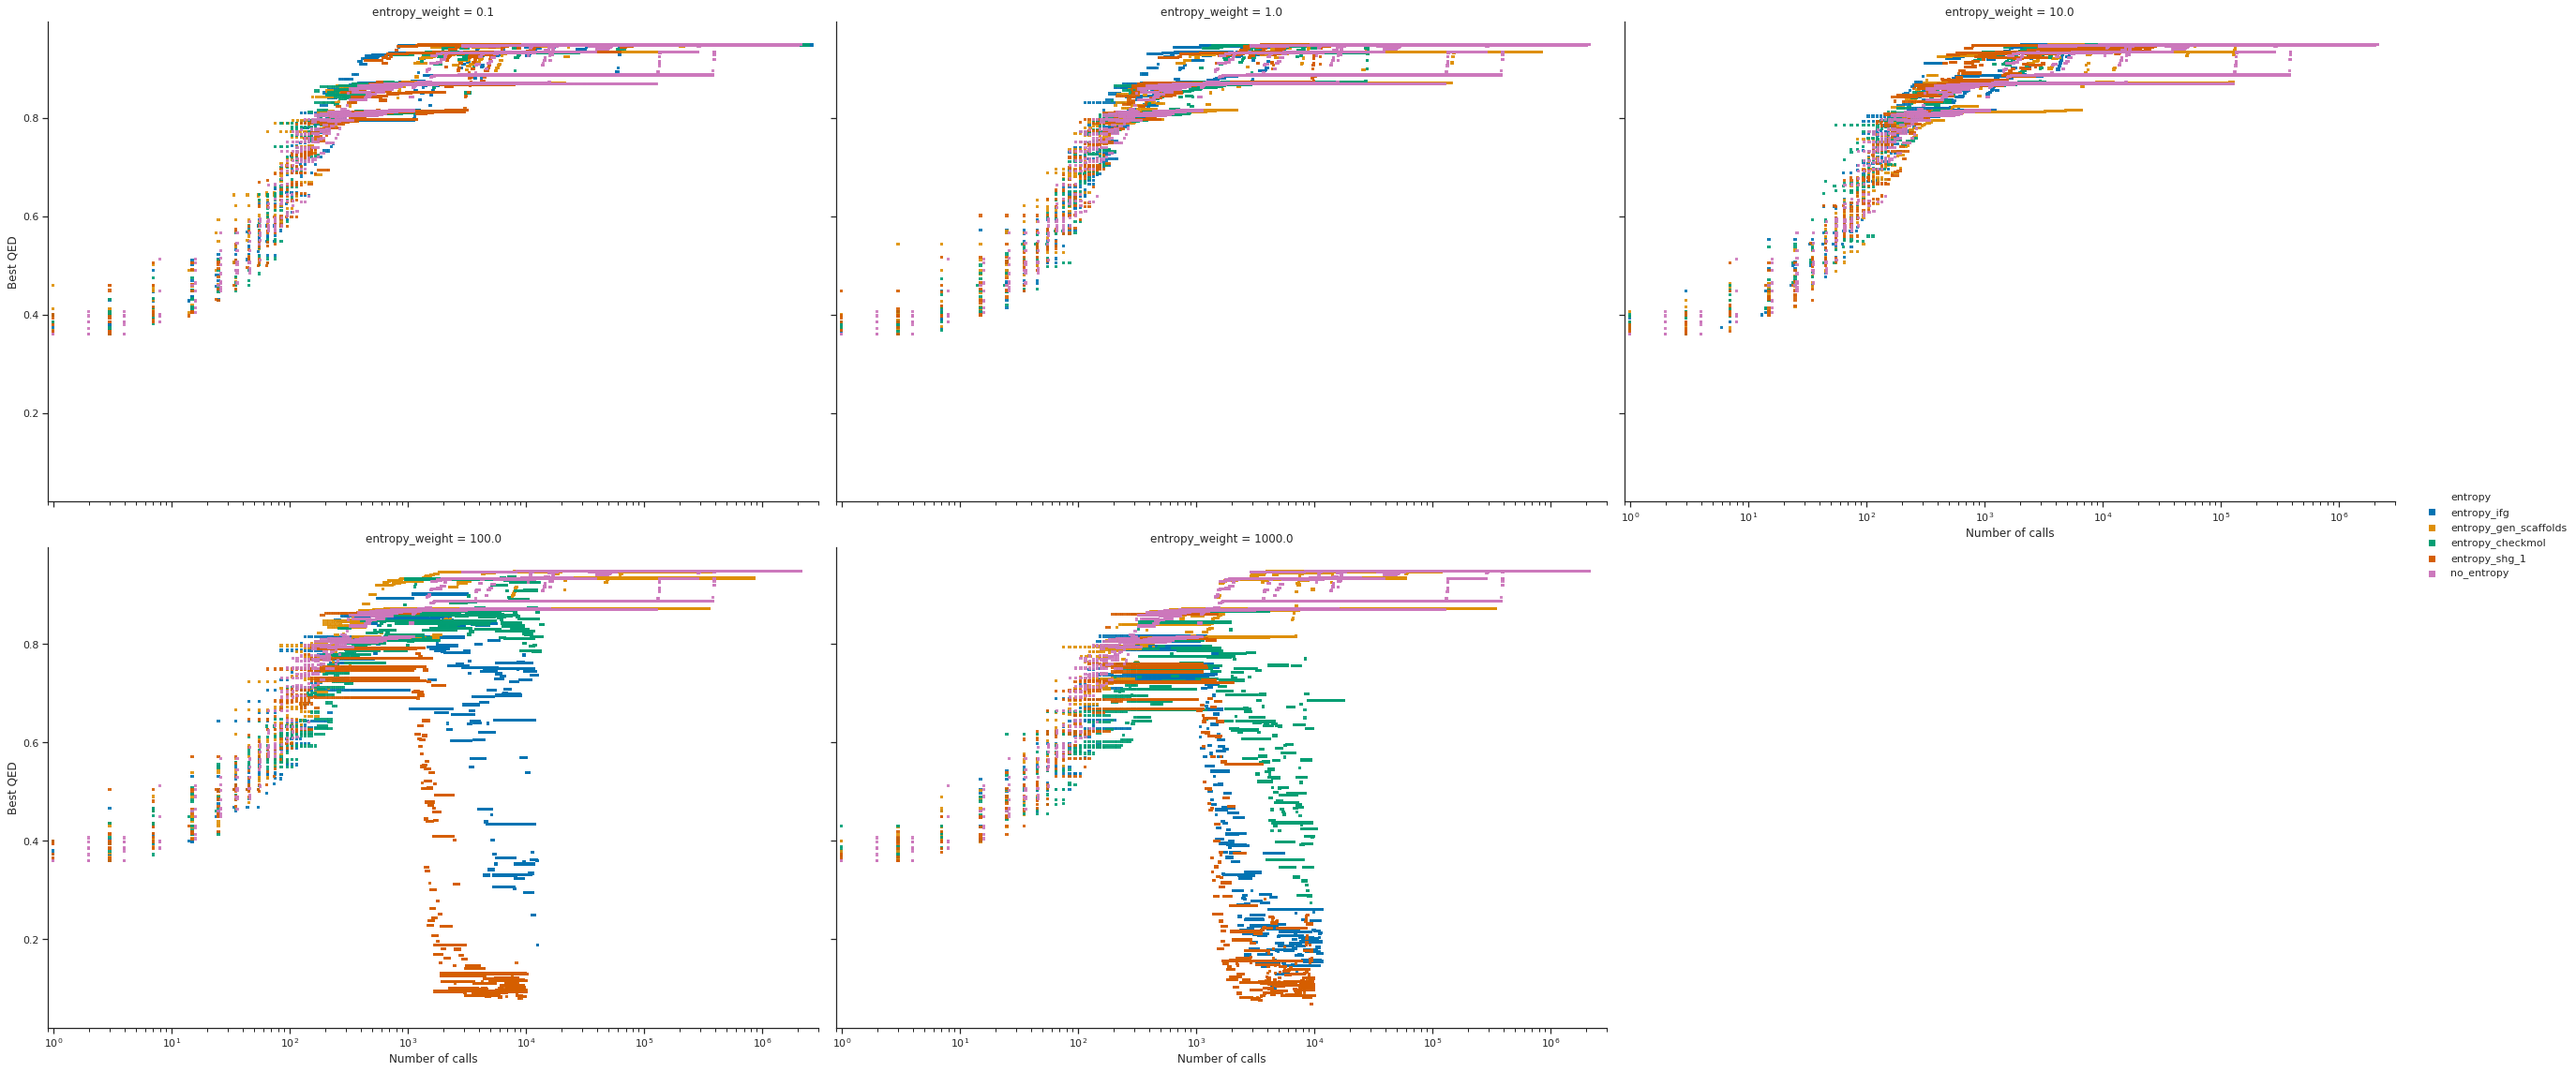

In [5]:
plot_score_vs_calls("max")

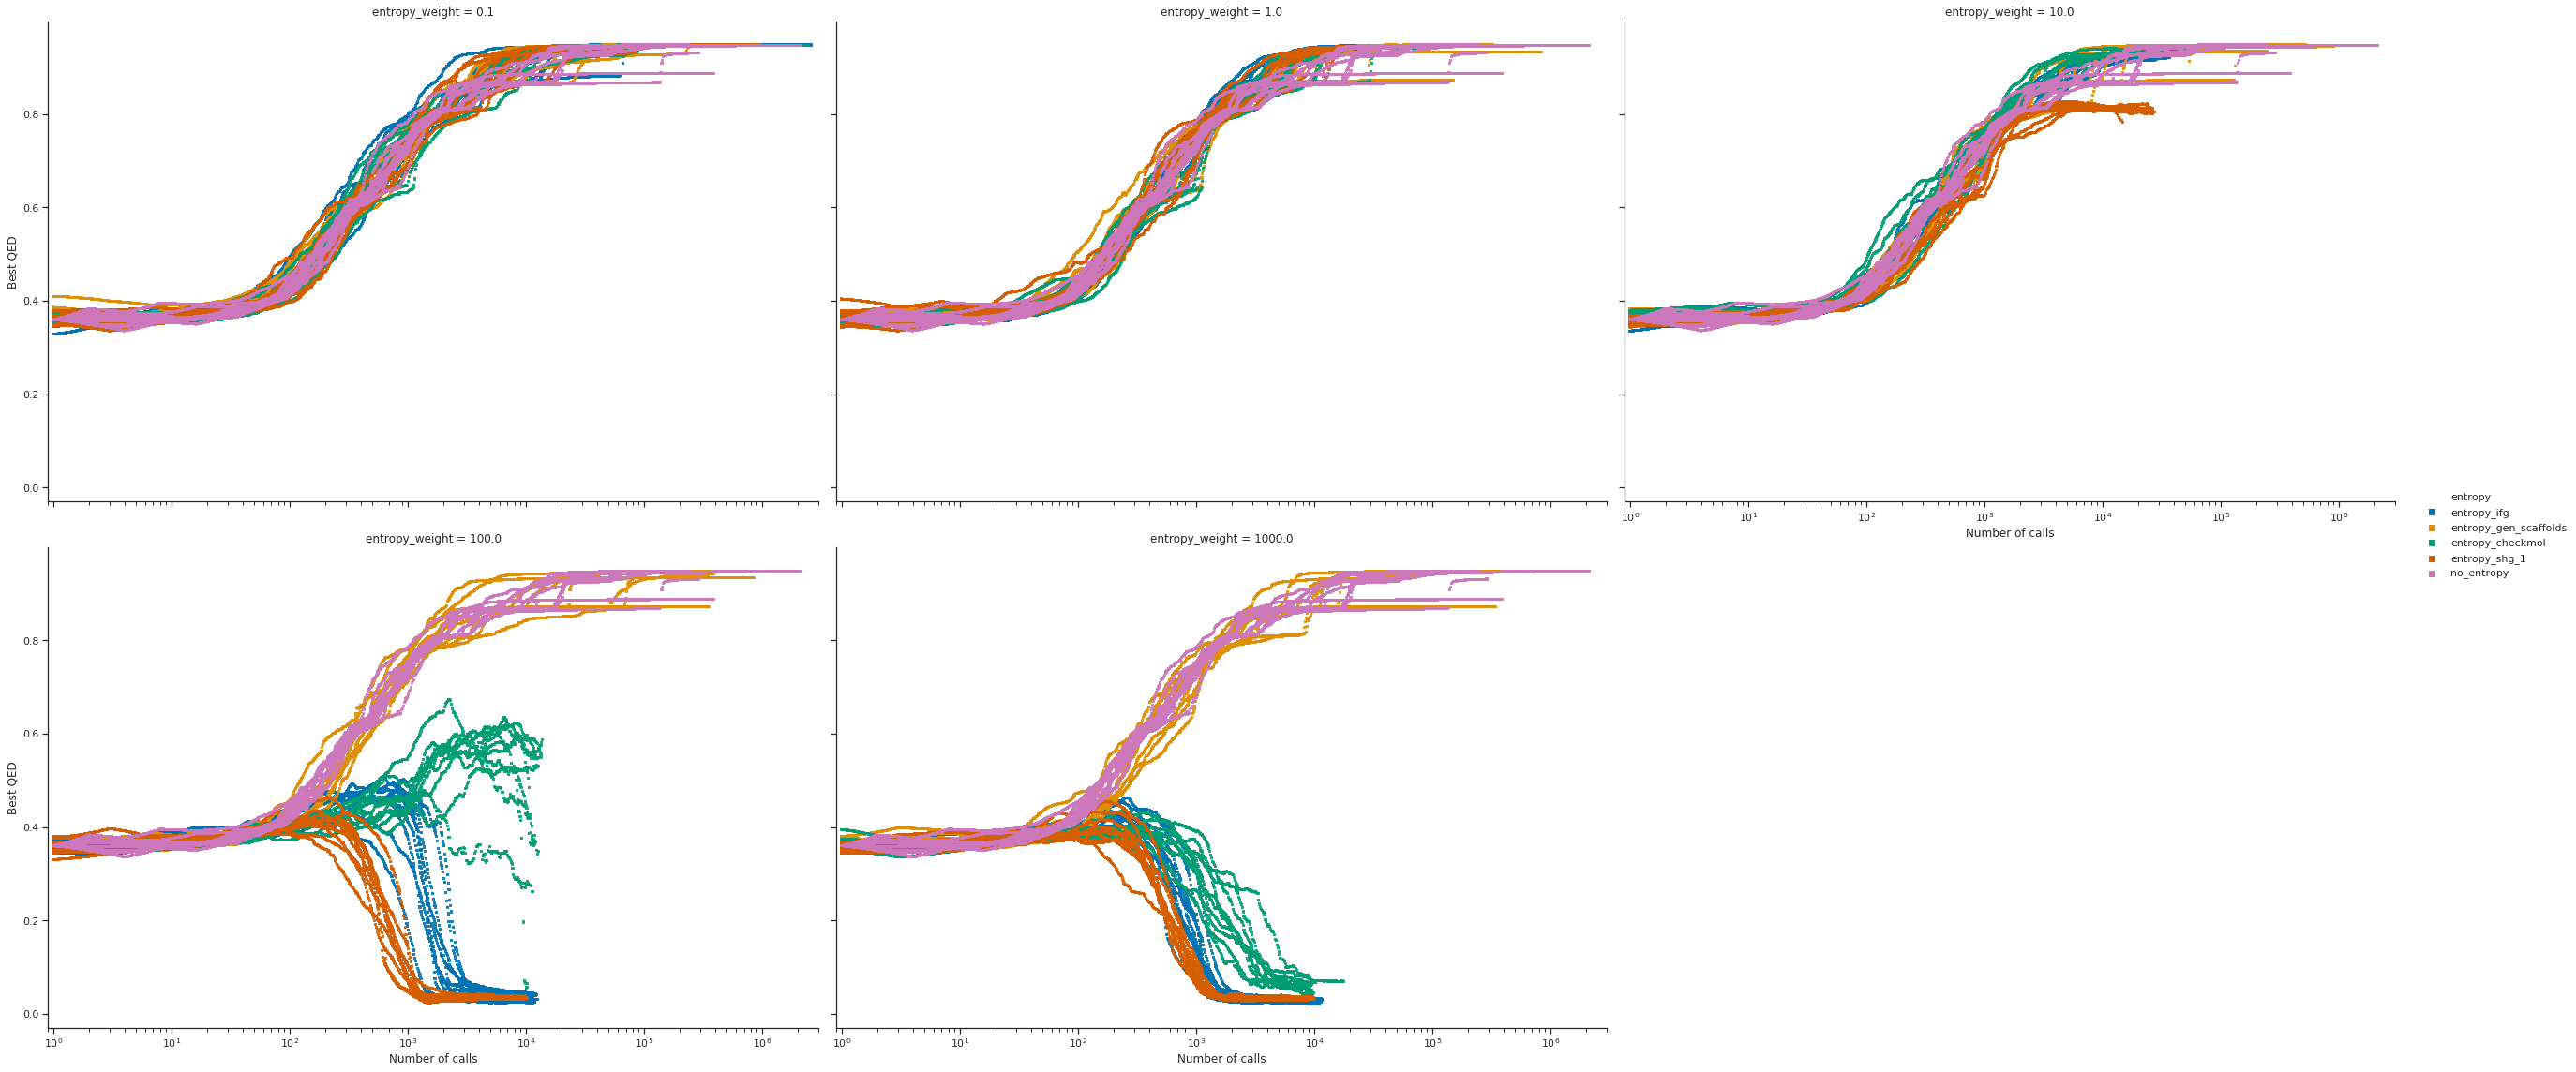

In [6]:
plot_score_vs_calls("med", normalize_x_ticks=True)

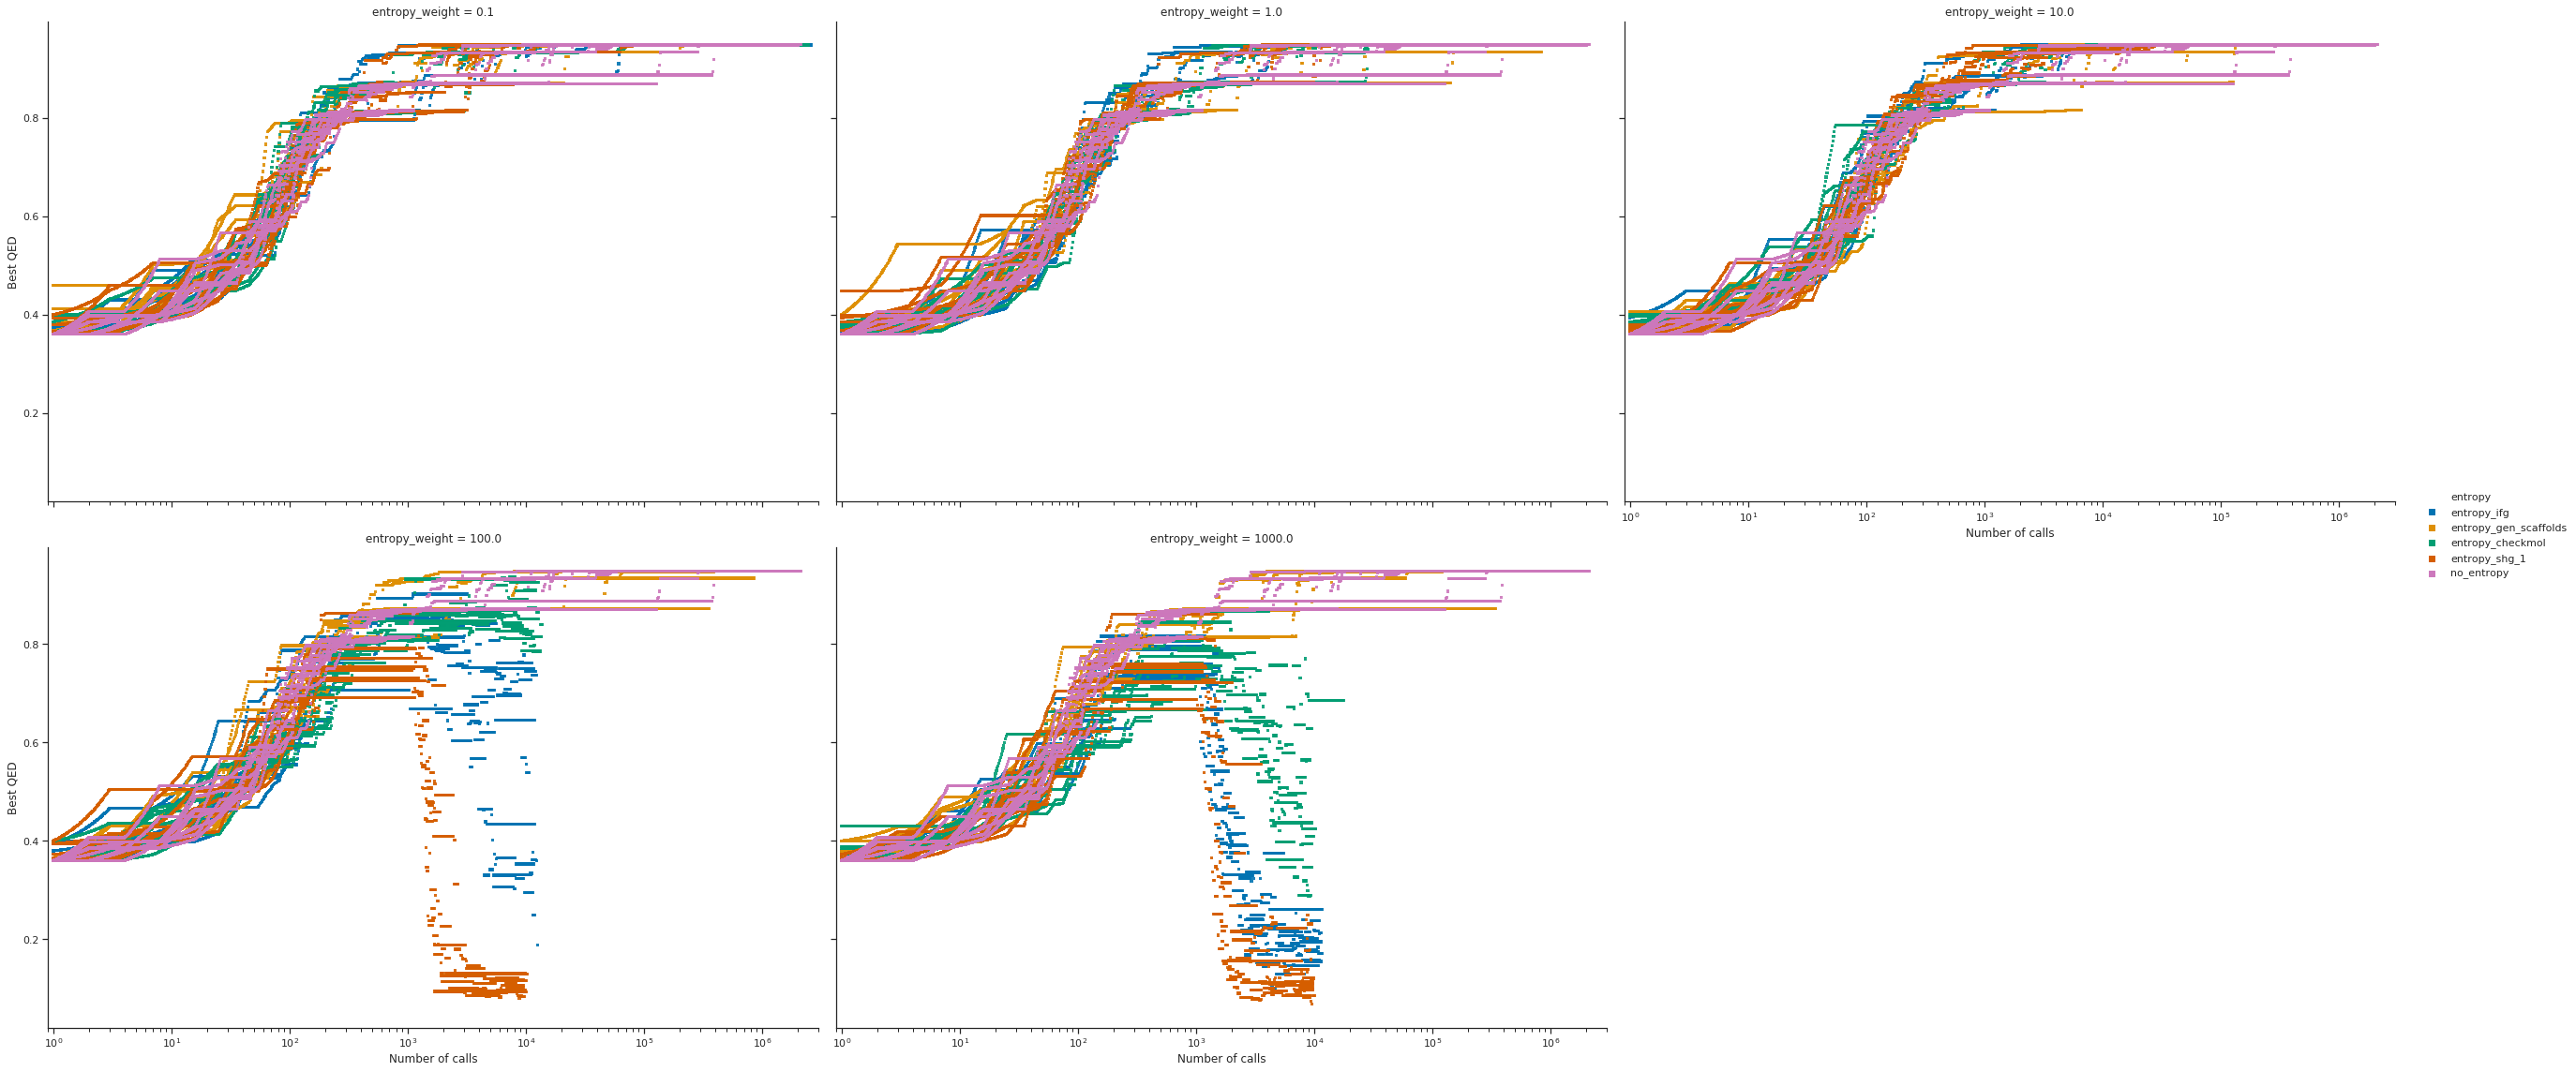

In [7]:
plot_score_vs_calls("max", normalize_x_ticks=True)

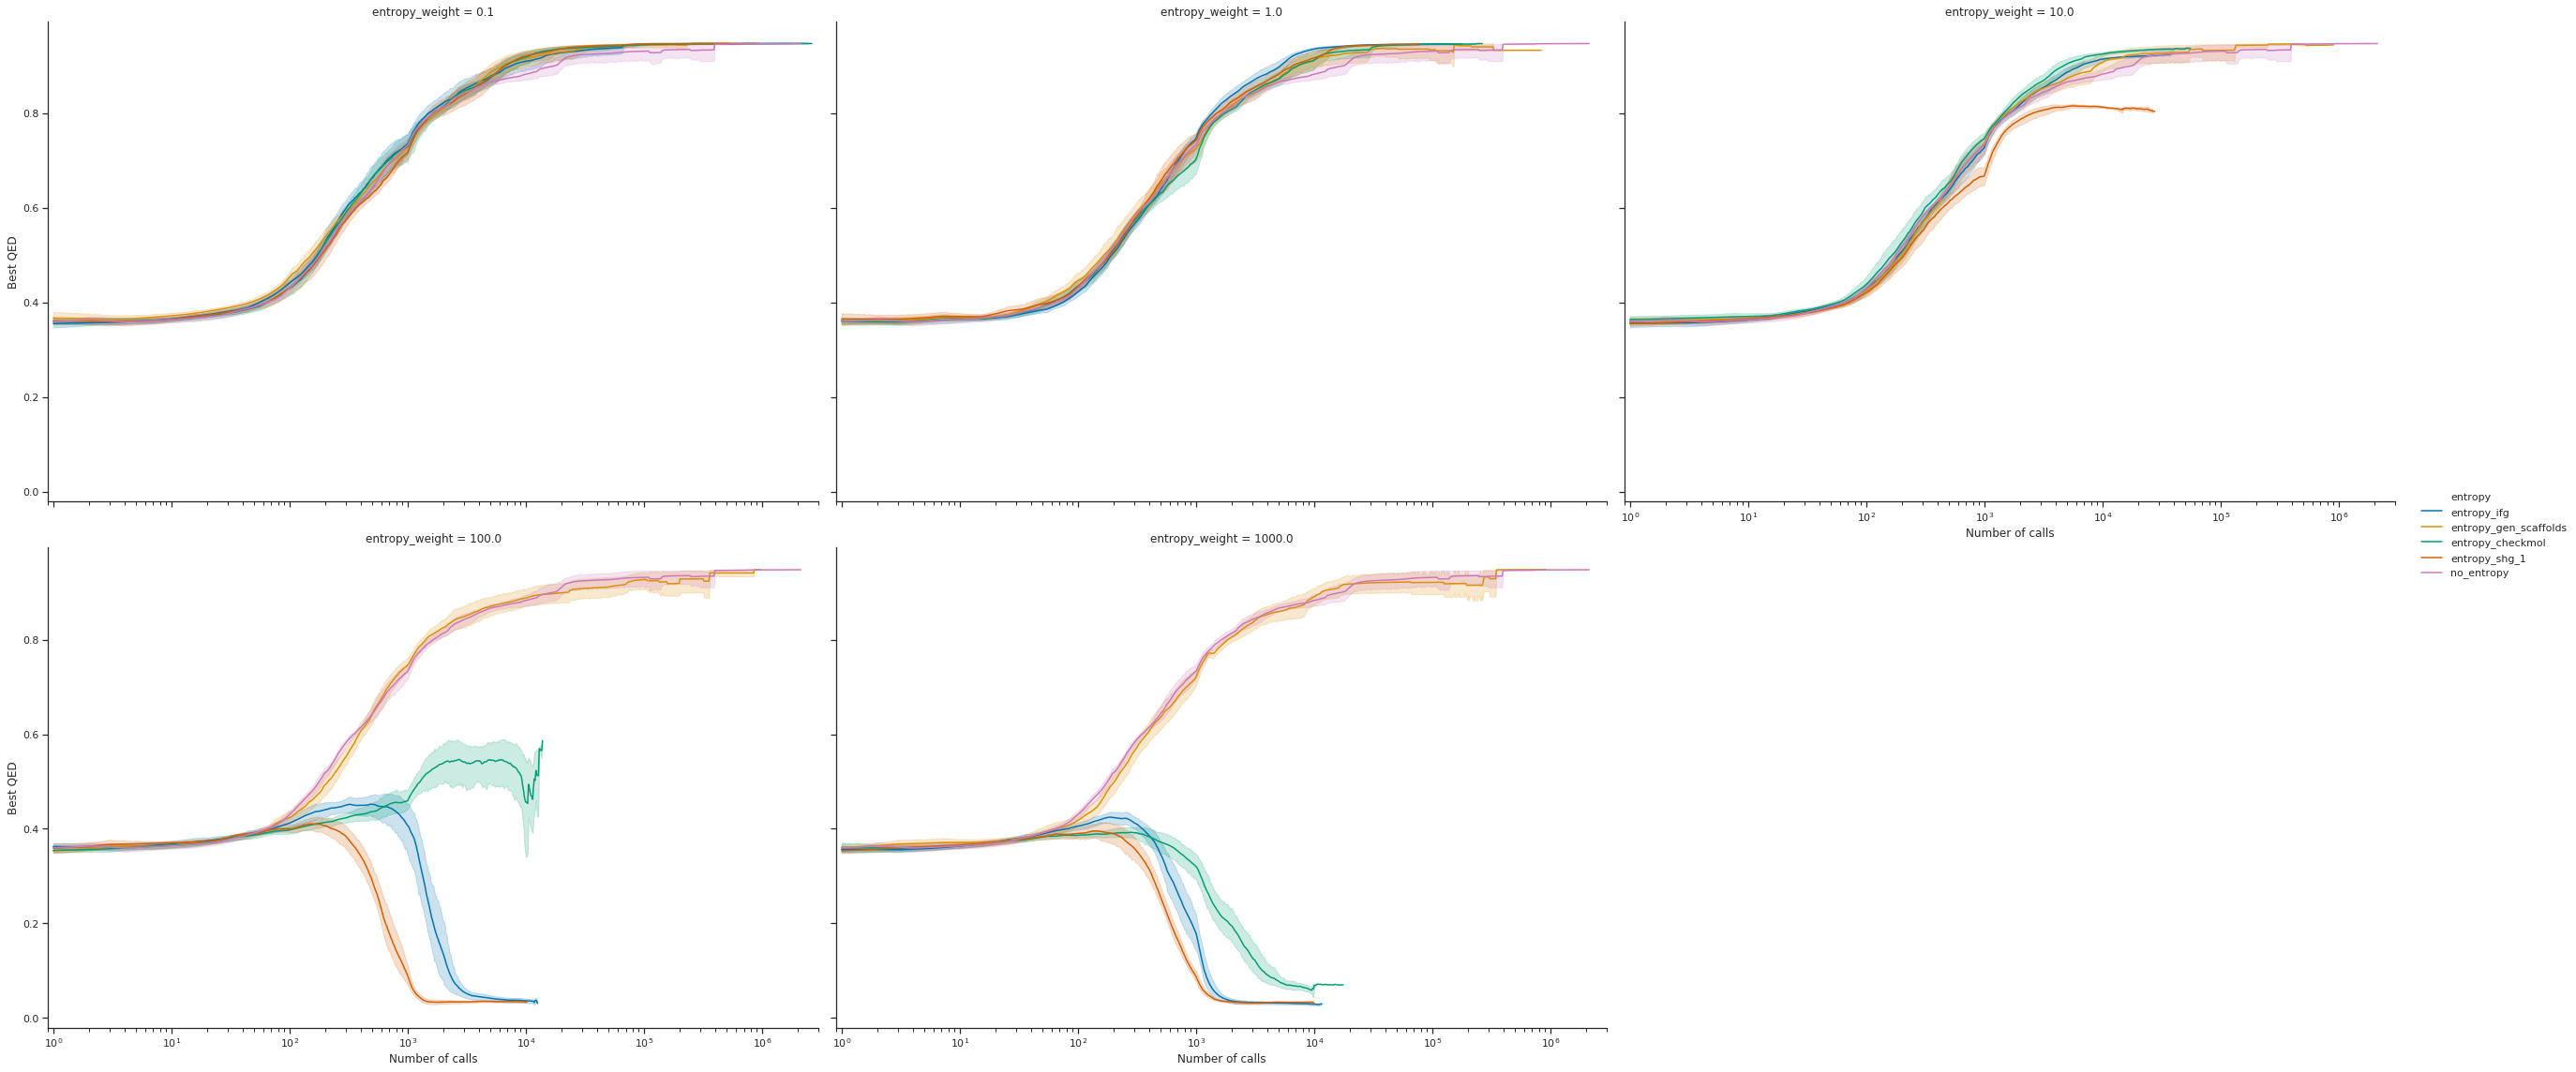

In [8]:
plot_score_vs_calls("med", normalize_x_ticks=True, kind="line")

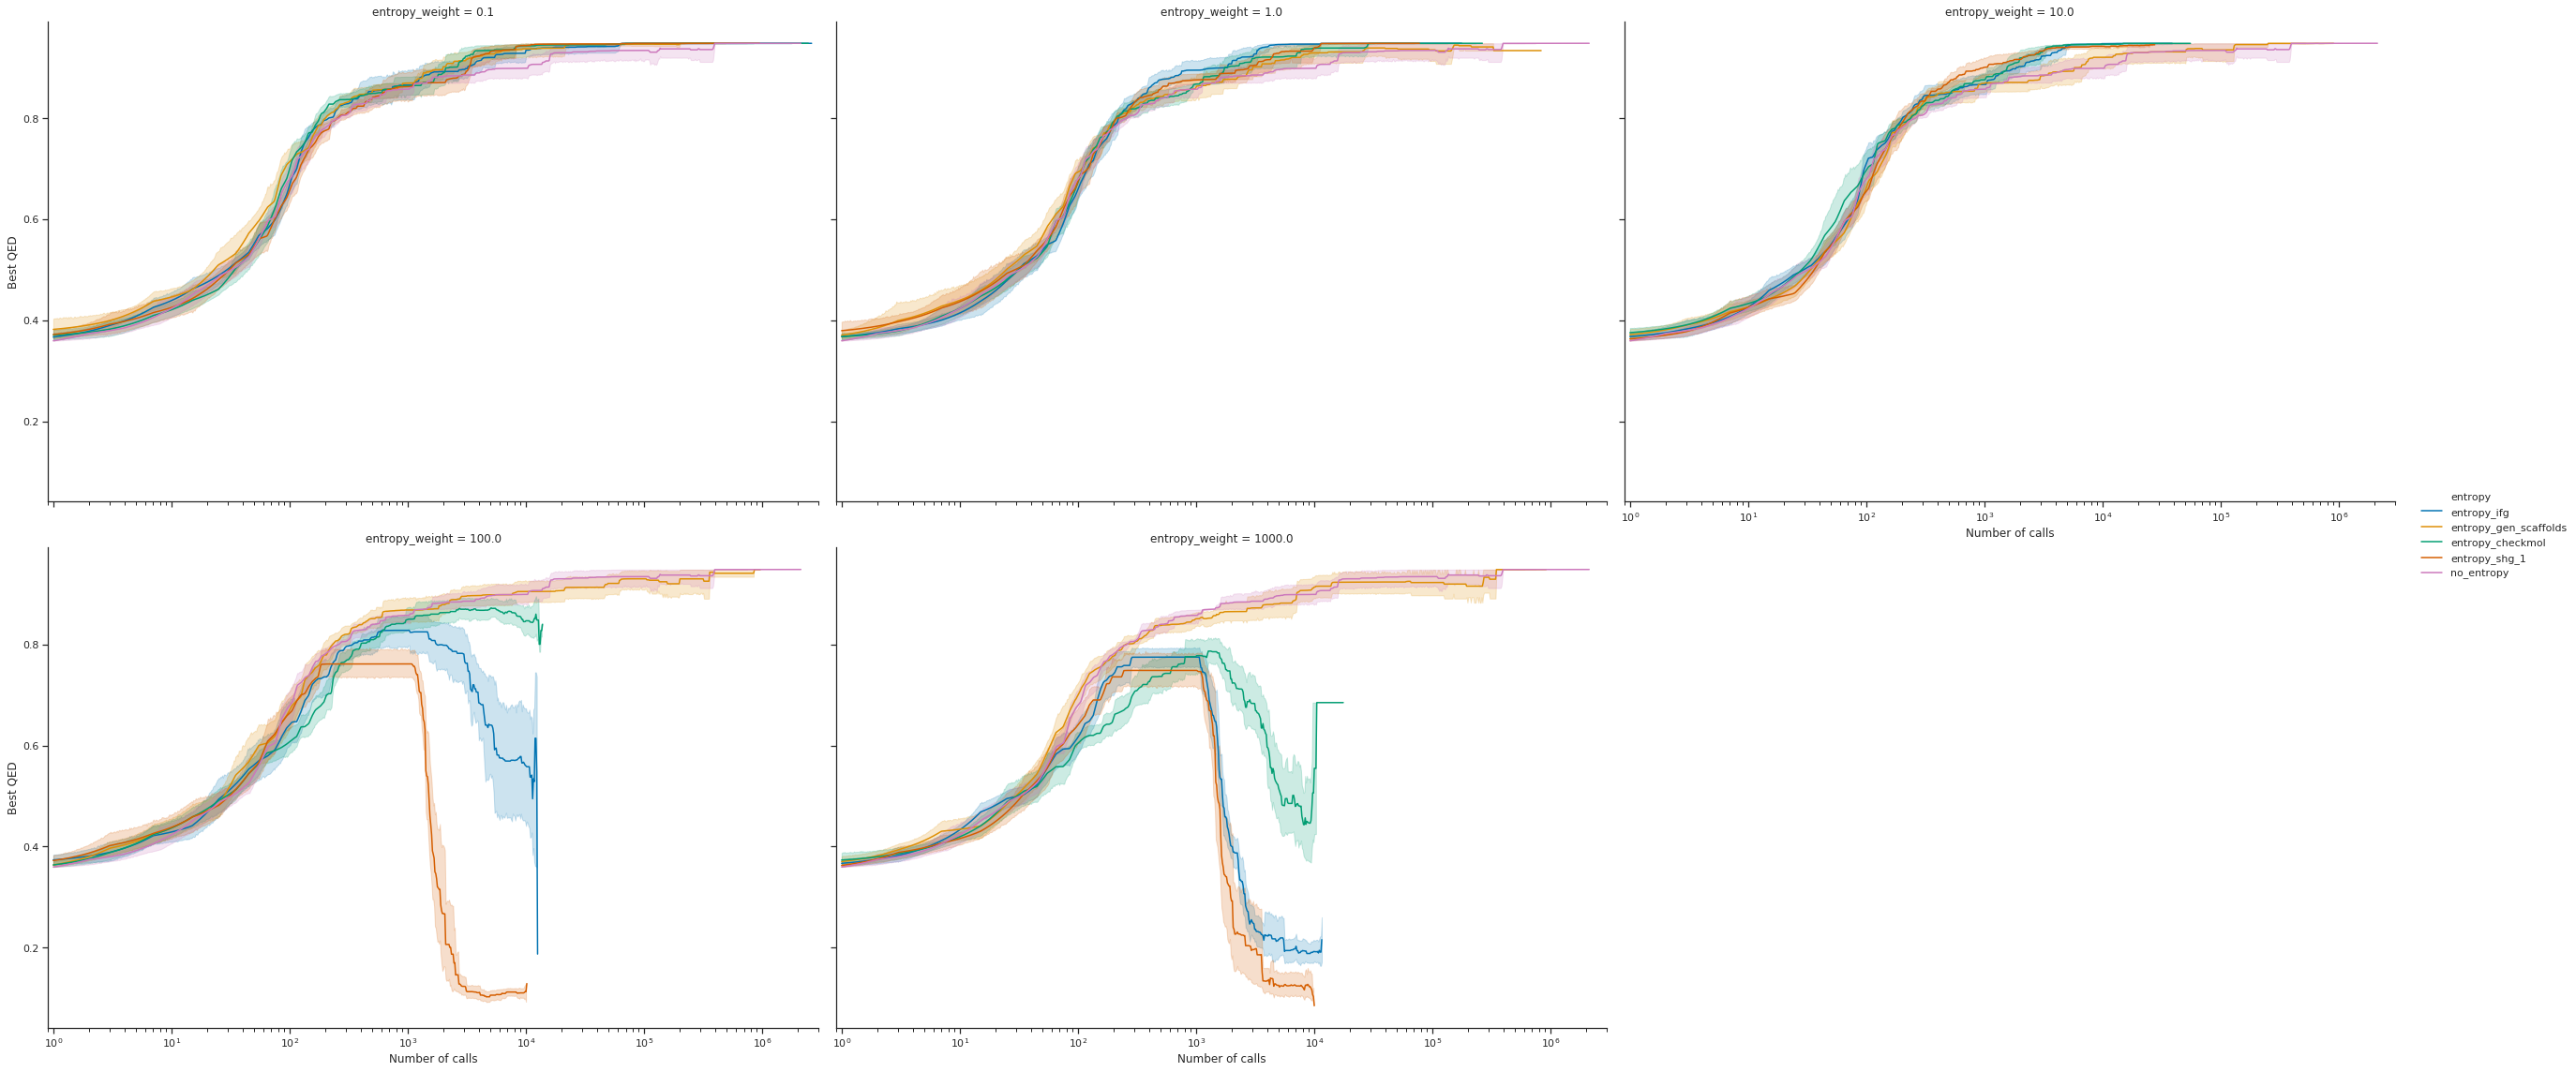

In [9]:
plot_score_vs_calls("max", normalize_x_ticks=True, kind="line")

In [10]:


def extract_convergence_vs_calls(steps_path, convergence_key, curr_batch_max_calls=None):
    
    with open(steps_path, "r") as f:
        steps_dict = pd.read_csv(f)
        
        convergence = np.array(steps_dict["qed_"+convergence_key])
        calls = np.array(steps_dict["objective_calls"])
        
        # Adding a final point of the last QED value at the maximum call numbers encoutered during the batch of 10 experiments 
        if curr_batch_max_calls is not None and max(calls) < curr_batch_max_calls:
            convergence = np.concatenate([convergence, np.array([convergence[-1]])])
            calls = np.concatenate([calls, [curr_batch_max_calls]])
            
    return convergence, calls
        
        
def extract_all_data(convergence_key, normalize_x_ticks=False):
    
    d = {
        "run_id": np.array([]),
        "entropy_weight": np.array([]),
        "entropy": np.array([]),
        convergence_key + " qed": np.array([]),
        "# calls": np.array([])
    }
    
    for i in range(210):
        
           
        # Finding max number of calls for the batch of experiments
        if i%10 == 0:
            curr_batch_max_calls = 0
            for j in range(i, i+10):
                
                entropy_weight, entropy_function, run_id = model_id_to_model_params(j)
                model_path = compute_model_path(entropy_weight, entropy_function, run_id)
                convergence, calls = extract_convergence_vs_calls(join(model_path, "steps.csv"), convergence_key)
                curr_batch_max_calls = max(curr_batch_max_calls, max(calls))
           
        entropy_weight, entropy_function, run_id = model_id_to_model_params(i)
        model_path = compute_model_path(entropy_weight, entropy_function, run_id)
        
        convergence, calls = extract_convergence_vs_calls(join(model_path, "steps.csv"), convergence_key, curr_batch_max_calls)
        
        if normalize_x_ticks:
            convergence, calls = normalizer_x_ticks(convergence, calls)
                    
        run_id = np.full(convergence.shape, run_id)
        entropy_weight = np.full(convergence.shape, entropy_weight)
        entropy = np.full(convergence.shape, entropy_function)
        

        d["run_id"] = np.concatenate([d["run_id"], run_id])
        d["entropy_weight"] = np.concatenate([d["entropy_weight"], entropy_weight])
        d["entropy"] = np.concatenate([d["entropy"], entropy])
        d[convergence_key + " qed"] = np.concatenate([d[convergence_key + " qed"], convergence])
        d["# calls"] = np.concatenate([d["# calls"], calls])
        
    return pd.DataFrame.from_dict(d)


In [11]:

def plot_score_vs_calls_1desc(convergence_key, desc, normalize_x_ticks=False):
    
    if desc == "entropy_ifg":
        ent_type = "IFG"
    elif desc == "entropy_gen_scaffolds":
        ent_type = "generic scaffolds"
    elif desc == "entropy_shg_1":
        ent_type = "lvl. 1 shingles"
    elif desc == "entropy_checkmol":
        ent_type = "checkmol"
    
    makedirs(output_figures_path, exist_ok=True)
    
    d = extract_all_data(convergence_key, normalize_x_ticks=normalize_x_ticks)
    
    d["entropy_weight"] = d["entropy_weight"].astype(str)
    d = d[np.logical_or(d["entropy"] == desc, d["entropy"] == "no_entropy")]
        
    plt.figure(figsize=(3/2*8, 8))

    p = sns.lineplot(
        data=d,
        x="# calls", y=convergence_key + " qed",
        hue="entropy_weight", style="entropy", legend="full", palette=sns.color_palette("colorblind")[:6]
    )
    
    plt.legend(title="Entropy weight (" + ent_type + ")", 
               labels=p.get_legend_handles_labels()[-1][1:7])._legend_box.align = "left"
    
    plt.xscale("log")    
    p.set(xlim=(1,3000000))
    p.set(ylim=(0, 1))
    p.set(xlabel="Number of calls", ylabel="Best QED")
    
    
    if normalize_x_ticks:
        filename = "line" + "_" + desc + "_convergence_regular_ticks" + convergence_key + ".png"
    else:
        filename = "line" + "_" + desc +"_convergence_" + convergence_key + ".png"

    plt.tight_layout()
    plt.savefig(join(output_figures_path, filename), dpi=300)


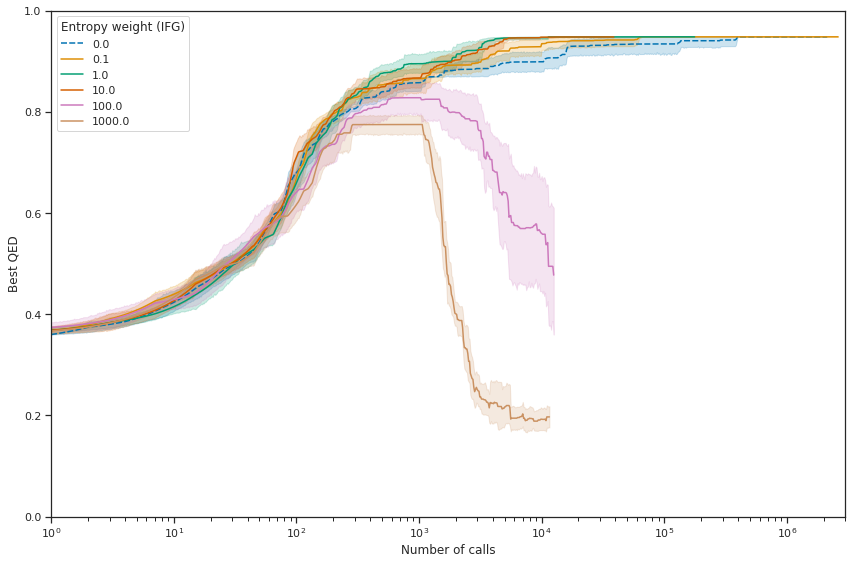

In [12]:
plot_score_vs_calls_1desc("max", "entropy_ifg", True)

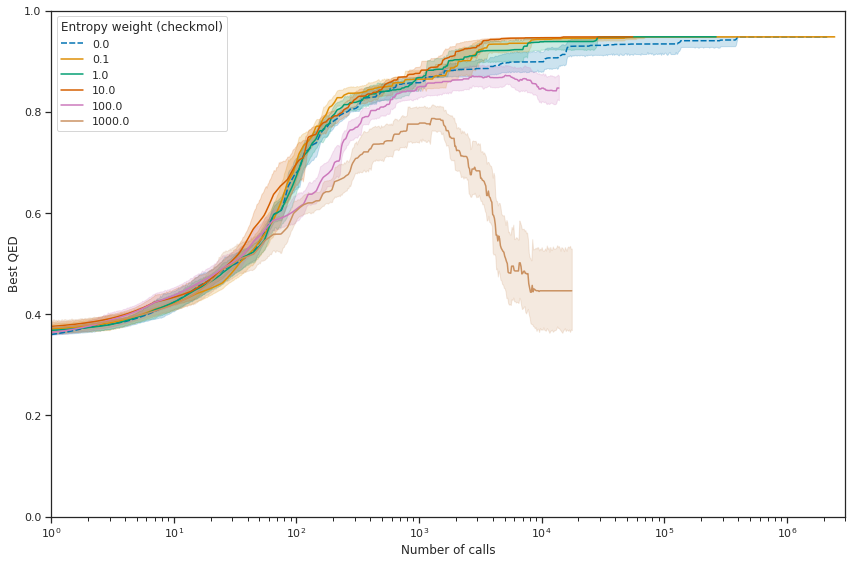

In [13]:
plot_score_vs_calls_1desc("max", "entropy_checkmol", True)

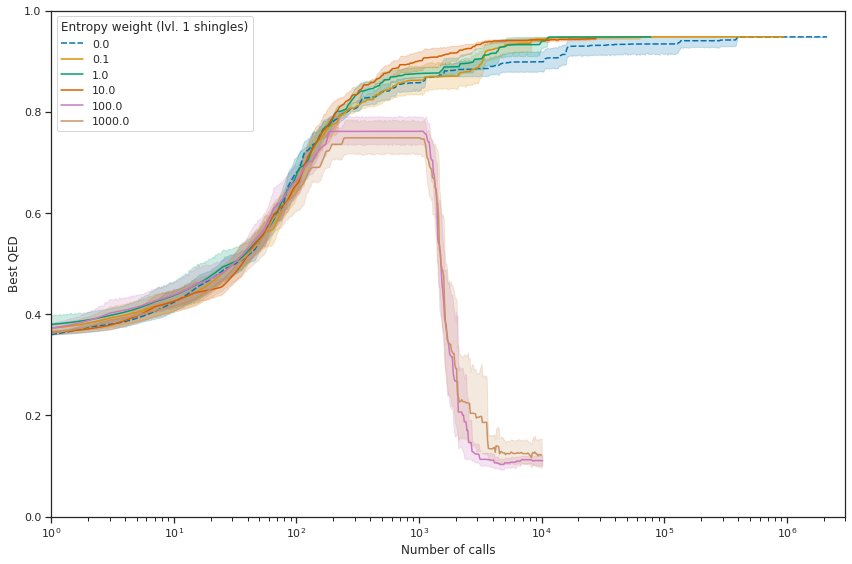

In [14]:
plot_score_vs_calls_1desc("max", "entropy_shg_1", True)

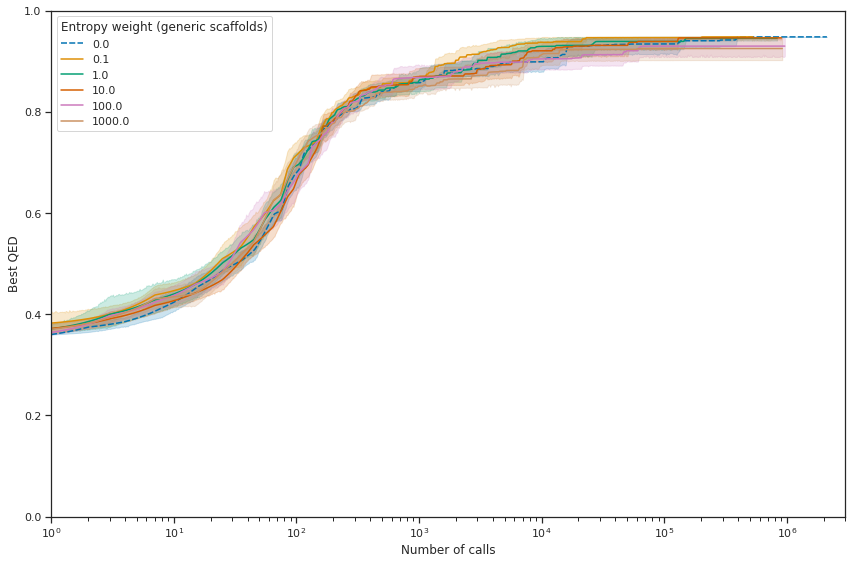

In [15]:
plot_score_vs_calls_1desc("max", "entropy_gen_scaffolds", True)

In [22]:
import csv
from os.path import join

def build_fake_all_generated(model_path):
    print(model_path)
    with open(join(model_path, "steps.csv"), "r") as f:
        reader = csv.reader(f)
        qed_max_values = []
        call_num = []
        steps = []
        best_qed = -float("inf")
        for i,row in enumerate(reader):
            if i > 0:
                
                curr_qed_val = float(row[3])
                
                if curr_qed_val > best_qed:
                    
                    best_qed = curr_qed_val
                
                    qed_max_values.append(float(row[3]))
                    steps.append(i)

                    if "no_entropy" in model_path:
                        call_num.append(int(row[10]))
                    else:
                        call_num.append(int(row[15]))

    
    with open(join(model_path, "all_generated.csv"), "w") as f:
        
        writer=csv.writer(f)
        
        writer.writerow(["step", "SMILES", "obj_calls", "obj_value", "improver", "success_obj_computation", "obj_computation_time", "qed"])
        
        for i in range(len(qed_max_values)):
            writer.writerow([
                steps[i], "", call_num[i], qed_max_values[i], True, True, 0.0, qed_max_values[i]
            ])
        
        

In [23]:
for i in range(210):
    entropy_weight, entropy_function, run_id = model_id_to_model_params(i)
    model_path = compute_model_path(entropy_weight, entropy_function, run_id)
    build_fake_all_generated(model_path)

/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_0.1_entropy_ifg/0
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_0.1_entropy_ifg/1
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_0.1_entropy_ifg/2
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_0.1_entropy_ifg/3
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_0.1_entropy_ifg/4
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_0.1_entropy_ifg/5
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_0.1_entropy_ifg/6
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_e

/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_10_entropy_gen_scaffolds/6
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_10_entropy_gen_scaffolds/7
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_10_entropy_gen_scaffolds/8
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_10_entropy_gen_scaffolds/9
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_10_entropy_checkmol/0
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_10_entropy_checkmol/1
/home/jleguy/Documents/these/prod/data/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/entropy_weight_10_entropy_checkmol/2
/home/jleguy/Document

In [4]:
from bbomol.postprocessing.plot import display_ert
from bbomol.postprocessing.postprocessing import load_complete_input_results
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.6f' % x)


for desc in entropy_functions:
    print(desc)

    evomol_d = {}
    for weight in entropy_weights:
        
        if weight == 0:
            w = "0_no_entropy"
            d = ""
        else:
            w = str(weight)
            d = "_" + desc
        
        evomol_d[weight]= os.environ["DATA"] + "/04_diversity/paper/04.05_new_entropy_qed_10_runs_count_calls/" + "entropy_weight_" + w + "" + d

        
    results_dict = load_complete_input_results(BBO_experiments_dict={}, EvoMol_experiments_dict=evomol_d,
                                               sub_experiment_names=[str(i) for i in range(0, 10)])
    print("calc ert")
    display_ert(results_dict, ert_targets=[0.9, 0.94, 0.948])
            

entropy_ifg
calc ert


Experiment             0.9            0.94                     0.948
0    0.100000   9223.8 (10.0)  15431.8 (10.0)            23420.2 (10.0)
1    1.000000   1870.2 (10.0)   3523.7 (10.0)             6033.8 (10.0)
2   10.000000   2484.8 (10.0)   4089.1 (10.0)   8182.777777777777 (9.0)
3  100.000000    6010.0 (1.0)       inf (0.0)                 inf (0.0)
4 1000.000000       inf (0.0)       inf (0.0)                 inf (0.0)
5    0.000000  58993.6 (10.0)  84245.0 (10.0)  131973.11111111112 (9.0)

entropy_gen_scaffolds
calc ert


Experiment                       0.9                      0.94  \
0    0.100000             4205.0 (10.0)            27231.6 (10.0)   
1    1.000000            19970.2 (10.0)             39510.5 (8.0)   
2   10.000000            22322.6 (10.0)  31885.222222222223 (9.0)   
3  100.000000           23769.875 (8.0)  51913.666666666664 (6.0)   
4 1000.000000  53208.142857142855 (7.0)  61637.857142857145 (7.0)   
5    0.000000            58993.6 (10.0)            84245.0 (10.0)   

                      0.948  
0            36031.8 (10.0)  
1           47074.375 (8.0)  
2           51477.375 (8.0)  
3             98583.0 (5.0)  
4  123229.16666666667 (6.0)  
5  131973.11111111112 (9.0)

entropy_checkmol
calc ert


Experiment             0.9            0.94                     0.948
0    0.100000   2780.9 (10.0)  14698.1 (10.0)            63723.4 (10.0)
1    1.000000   5567.3 (10.0)   9071.7 (10.0)            14135.8 (10.0)
2   10.000000   1811.0 (10.0)   3977.7 (10.0)            10810.9 (10.0)
3  100.000000   14748.0 (2.0)       inf (0.0)                 inf (0.0)
4 1000.000000       inf (0.0)       inf (0.0)                 inf (0.0)
5    0.000000  58993.6 (10.0)  84245.0 (10.0)  131973.11111111112 (9.0)

entropy_shg_1
calc ert


Experiment             0.9            0.94                     0.948
0    0.100000   3270.6 (10.0)  11718.7 (10.0)            16475.5 (10.0)
1    1.000000   4169.9 (10.0)   5390.8 (10.0)             8635.5 (10.0)
2   10.000000   1334.4 (10.0)   8129.2 (10.0)                 inf (0.0)
3  100.000000       inf (0.0)       inf (0.0)                 inf (0.0)
4 1000.000000       inf (0.0)       inf (0.0)                 inf (0.0)
5    0.000000  58993.6 (10.0)  84245.0 (10.0)  131973.11111111112 (9.0)